In [2]:
import os
from pathlib import Path
#import tempfile
#import cv2
import numpy as np
#from colorthief import ColorThief
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.cluster import KMeans
#from skimage.filters.rank import entropy
#from skimage.morphology import disk
#from PIL import Image, ImageStat
#from skimage import img_as_float
import pandas as pd
#from multiprocessing import Process
#import matplotlib.image as img
import matplotlib.pyplot as plt
import statistics
from scipy import spatial
#from numba import jit

<h1> Imported datasets </h1>

In [4]:
#ratings = pd.read_csv('./ml-20m/ratings.csv')
#movie_list = pd.read_csv('movie_assets_sampled.csv')

# In case I do not have time to run the program
# The outputted features have been added to a CSV file 
movie_df = pd.read_csv('./datasets/output.csv')
shot_df = pd.read_csv('./datasets/shot_data.csv')

movie_df = movie_df.drop(columns=['Unnamed: 0', 'sharpness'])
shot_df = shot_df.drop(columns='Unnamed: 0')

movie_df.head()

,saturation,brightness,entropy,contrast,frame_nr,colorfulness,col_palette,movie_id
0,48.620459,41.318256,4.449458,62.055632,0,38.521991,"[(28, 60, 48), (198, 196, 168), (129, 99, 87),...",tt12316630.mp4
1,13.313068,44.688463,3.037550,63.074007,49,11.809414,"[(56, 60, 52), (165, 181, 161), (190, 207, 186...",tt12316630.mp4
2,25.738858,43.961366,3.121975,77.422133,109,13.806843,"[(38, 47, 47), (217, 230, 210), (160, 174, 155...",tt12316630.mp4
3,15.886666,51.800640,3.277400,56.934361,133,15.459579,"[(104, 113, 99), (212, 226, 198), (175, 190, 1...",tt12316630.mp4
4,14.471347,58.068028,2.979327,61.155942,160,17.518376,"[(95, 106, 93), (219, 232, 202), (184, 199, 17...",tt12316630.mp4


In [7]:
shot_df = shot_df.rename(columns = {'mean_shot_time': 'median_shot_time'})
shot_df.head()


,average_shot_time,median_shot_time,movie_id,shots_per_second,stdev_shot_time
0,1.618440,1.533333,tt12316630.mp4,0.617879,0.792100
1,1.294845,1.080000,tt7558302.mp4,0.772293,0.709585
2,1.548533,1.339596,tt2429638.mp4,0.645772,0.826346
3,1.606215,1.126125,tt4633690.mp4,0.622582,1.592320
4,1.609451,1.167833,tt6146586.mp4,0.621330,1.049800


# Split color palette


In [8]:
df = movie_df.copy()
df = df.replace('\[','', regex=True)
df = df.replace('\]','', regex=True)

df = df.replace('\),',').', regex=True)

print(df['col_palette'])

df[['dom_col1', 'dom_col2', 'dom_col3', 'dom_col4', 'dom_col5']] = df['col_palette'].str.split('.',0,expand=True)

df = df.replace('\)','', regex=True)
df = df.replace('\(','', regex=True)


#df[['dom_col1_r', 'dom_col1_g', 'dom_col1_b']] = df['dom_col1'].str.split(',',0,expand=True).astype(int)
#df[['dom_col2_r', 'dom_col2_g', 'dom_col2_b']] = df['dom_col2'].str.split(',',0,expand=True).astype(int)
#df[['dom_col3_r', 'dom_col3_g', 'dom_col3_b']] = df['dom_col3'].str.split(',',0,expand=True).astype(int)
#df[['dom_col4_r', 'dom_col4_g', 'dom_col4_b']] = df['dom_col4'].str.split(',',0,expand=True).astype(int)
#df[['dom_col5_r', 'dom_col5_g', 'dom_col5_b']] = df['dom_col5'].str.split(',',0,expand=True).astype(int)

#df=df.drop(columns=['col_palette','dom_col1', 'dom_col2', 'dom_col3', 'dom_col4', 'dom_col5'])


movie_df = df
#extract_palette_list = extract_palette.values.tolist()
#print(extract_palette_list)
df.head()

0        28, 60, 48. 198, 196, 168. 129, 99, 87. 144, 1...
1        56, 60, 52. 165, 181, 161. 190, 207, 186. 140,...
2        38, 47, 47. 217, 230, 210. 160, 174, 155. 129,...
3        104, 113, 99. 212, 226, 198. 175, 190, 165. 36...
4        95, 106, 93. 219, 232, 202. 184, 199, 175. 165...
                               ...                        
58335    85, 34, 7. 227, 197, 83. 237, 224, 172. 187, 1...
58336    4, 4, 4. 217, 217, 217. 83, 83, 83. 124, 124, ...
58337    4, 4, 4. 217, 217, 217. 84, 84, 84. 124, 124, ...
58338    4, 4, 4. 217, 217, 217. 83, 83, 83. 124, 124, ...
58339    4, 4, 4. 218, 218, 218. 84, 84, 84. 124, 124, ...
Name: col_palette, Length: 58340, dtype: object


,saturation,brightness,entropy,contrast,frame_nr,colorfulness,col_palette,movie_id,dom_col1,dom_col2,dom_col3,dom_col4,dom_col5
0,48.620459,41.318256,4.449458,62.055632,0,38.521991,"28, 60, 48. 198, 196, 168. 129, 99, 87. 144, 1...",tt12316630.mp4,"28, 60, 48","198, 196, 168","129, 99, 87","144, 172, 149","131, 156, 157"
1,13.313068,44.688463,3.037550,63.074007,49,11.809414,"56, 60, 52. 165, 181, 161. 190, 207, 186. 140,...",tt12316630.mp4,"56, 60, 52","165, 181, 161","190, 207, 186","140, 153, 136","155, 164, 156"
2,25.738858,43.961366,3.121975,77.422133,109,13.806843,"38, 47, 47. 217, 230, 210. 160, 174, 155. 129,...",tt12316630.mp4,"38, 47, 47","217, 230, 210","160, 174, 155","129, 141, 125","140, 155, 156"
3,15.886666,51.800640,3.277400,56.934361,133,15.459579,"104, 113, 99. 212, 226, 198. 175, 190, 165. 36...",tt12316630.mp4,"104, 113, 99","212, 226, 198","175, 190, 165","36, 47, 45","179, 197, 180"
4,14.471347,58.068028,2.979327,61.155942,160,17.518376,"95, 106, 93. 219, 232, 202. 184, 199, 175. 165...",tt12316630.mp4,"95, 106, 93","219, 232, 202","184, 199, 175","165, 178, 155","172, 188, 180"


<h1> Helper functions </h1>

In [9]:
# Averages a list
def average(l):
    return sum(l) / len(l)

# Makes a list of unique values from a list
def unique(list1):
    # Init null list
    unique_list = []

    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
            #print(x)
    return unique_list

<h1> Condensing all features to single rows per movie </h1>

In [5]:
# Polynomial regression on the movies
# Currently all values are formatted as strings (might be changed later)
def polynomial_regression_alt(df, id):
    temp_df = df
    temp_df['frame_nr'] = pd.to_numeric(temp_df['frame_nr'], downcast='integer')
    temp_df = temp_df.sort_values(by=['frame_nr'], axis=0, ascending=True)
    output = pd.DataFrame()


    frame_nr = temp_df['frame_nr'][temp_df['movie_id'] == id]
    saturation = temp_df['saturation'][temp_df['movie_id'] == id]
    brightness = temp_df['brightness'][temp_df['movie_id'] == id]
    entropy = temp_df['entropy'][temp_df['movie_id'] == id]
    #sharpness = temp_df['sharpness'][temp_df['movie_id'] == id]
    contrast = temp_df['contrast'][temp_df['movie_id'] == id]
    colorfulness = temp_df['colorfulness'][temp_df['movie_id'] == id]
    dom_col1_r = temp_df['dom_col1_r'][temp_df['movie_id'] == id]
    dom_col1_g = temp_df['dom_col1_g'][temp_df['movie_id'] == id]
    dom_col1_b = temp_df['dom_col1_b'][temp_df['movie_id'] == id]
    dom_col2_r = temp_df['dom_col2_r'][temp_df['movie_id'] == id]
    dom_col2_g = temp_df['dom_col2_g'][temp_df['movie_id'] == id]
    dom_col2_b = temp_df['dom_col2_b'][temp_df['movie_id'] == id]
    dom_col3_r = temp_df['dom_col3_r'][temp_df['movie_id'] == id]
    dom_col3_g = temp_df['dom_col3_g'][temp_df['movie_id'] == id]
    dom_col3_b = temp_df['dom_col3_b'][temp_df['movie_id'] == id]
    dom_col4_r = temp_df['dom_col4_r'][temp_df['movie_id'] == id]
    dom_col4_g = temp_df['dom_col4_g'][temp_df['movie_id'] == id]
    dom_col4_b = temp_df['dom_col4_b'][temp_df['movie_id'] == id]
    dom_col5_r = temp_df['dom_col5_r'][temp_df['movie_id'] == id]
    dom_col5_g = temp_df['dom_col5_g'][temp_df['movie_id'] == id]
    dom_col5_b = temp_df['dom_col5_b'][temp_df['movie_id'] == id]


    saturation_model_1st = np.poly1d(np.polyfit(frame_nr, saturation, 1))
    brightness_model_1st = np.poly1d(np.polyfit(frame_nr, brightness, 1))
    entropy_model_1st = np.poly1d(np.polyfit(frame_nr, entropy, 1))
    #sharpness_model_1st = str(np.poly1d(np.polyfit(frame_nr, sharpness, 1)))
    contrast_model_1st = np.poly1d(np.polyfit(frame_nr, contrast, 1))
    colorfulness_model_1st = np.poly1d(np.polyfit(frame_nr, colorfulness, 1))
    dom_col1_r_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col1_r, 1))
    dom_col1_g_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col1_g, 1))
    dom_col1_b_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col1_b, 1))
    dom_col2_r_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col2_r, 1))
    dom_col2_g_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col2_g, 1))
    dom_col2_b_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col2_b, 1))
    dom_col3_r_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col3_r, 1))
    dom_col3_g_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col3_g, 1))
    dom_col3_b_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col3_b, 1))
    dom_col4_r_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col4_r, 1))
    dom_col4_g_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col4_g, 1))
    dom_col4_b_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col4_b, 1))
    dom_col5_r_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col5_r, 1))
    dom_col5_g_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col5_g, 1))
    dom_col5_b_model_1st = np.poly1d(np.polyfit(frame_nr, dom_col5_b, 1))




    saturation_model_2nd = np.poly1d(np.polyfit(frame_nr, saturation, 2))
    brightness_model_2nd = np.poly1d(np.polyfit(frame_nr, brightness, 2))
    entropy_model_2nd = np.poly1d(np.polyfit(frame_nr, entropy, 2))
    #sharpness_model_2nd = str(np.poly1d(np.polyfit(frame_nr, sharpness, 2)))
    contrast_model_2nd = np.poly1d(np.polyfit(frame_nr, contrast, 2))
    colorfulness_model_2nd = np.poly1d(np.polyfit(frame_nr, colorfulness, 2))
    dom_col1_r_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col1_r, 2))
    dom_col1_g_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col1_g, 2))
    dom_col1_b_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col1_b, 2))
    dom_col2_r_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col2_r, 2))
    dom_col2_g_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col2_g, 2))
    dom_col2_b_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col2_b, 2))
    dom_col3_r_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col3_r, 2))
    dom_col3_g_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col3_g, 2))
    dom_col3_b_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col3_b, 2))
    dom_col4_r_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col4_r, 2))
    dom_col4_g_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col4_g, 2))
    dom_col4_b_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col4_b, 2))
    dom_col5_r_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col5_r, 2))
    dom_col5_g_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col5_g, 2))
    dom_col5_b_model_2nd = np.poly1d(np.polyfit(frame_nr, dom_col5_b, 2))



    
    polynomial_dict = {
        'movie_id': str(id),
        'saturation_model_1st': saturation_model_1st, 
        'brightness_model_1st': brightness_model_1st,
        'entropy_model_1st': entropy_model_1st,
        #'sharpness_model_1st': sharpness_model_1st,
        'contrast_model_1st': contrast_model_1st,
        'dom_col1_r_model_1st': dom_col1_r_model_1st,
        'dom_col1_g_model_1st': dom_col1_g_model_1st,
        'dom_col1_b_model_1st': dom_col1_b_model_1st,
        'dom_col2_r_model_1st': dom_col2_r_model_1st,
        'dom_col2_g_model_1st': dom_col2_g_model_1st,
        'dom_col2_b_model_1st': dom_col2_b_model_1st,
        'dom_col3_r_model_1st': dom_col3_r_model_1st,
        'dom_col3_g_model_1st': dom_col3_g_model_1st,
        'dom_col3_b_model_1st': dom_col3_b_model_1st,
        'dom_col4_r_model_1st': dom_col4_r_model_1st,
        'dom_col4_g_model_1st': dom_col4_g_model_1st,
        'dom_col4_b_model_1st': dom_col4_b_model_1st,
        'dom_col5_r_model_1st': dom_col5_r_model_1st,
        'dom_col5_g_model_1st': dom_col5_g_model_1st,
        'dom_col5_b_model_1st': dom_col5_b_model_1st,
        'colorfulness_model_1st': colorfulness_model_1st,
        'saturation_model_2nd': saturation_model_2nd,
        'brightness_model_2nd': brightness_model_2nd,
        'entropy_model_2nd': entropy_model_2nd,
        #'sharpness_model_2nd': sharpness_model_2nd,
        'contrast_model_2nd': contrast_model_2nd,
        'colorfulness_model_2nd': colorfulness_model_2nd,
        'dom_col1_r_model_2nd': dom_col1_r_model_2nd,
        'dom_col1_g_model_2nd': dom_col1_g_model_2nd,
        'dom_col1_b_model_2nd': dom_col1_b_model_2nd,
        'dom_col2_r_model_2nd': dom_col2_r_model_2nd,
        'dom_col2_g_model_2nd': dom_col2_g_model_2nd,
        'dom_col2_b_model_2nd': dom_col2_b_model_2nd,
        'dom_col3_r_model_2nd': dom_col3_r_model_2nd,
        'dom_col3_g_model_2nd': dom_col3_g_model_2nd,
        'dom_col3_b_model_2nd': dom_col3_b_model_2nd,
        'dom_col4_r_model_2nd': dom_col4_r_model_2nd,
        'dom_col4_g_model_2nd': dom_col4_g_model_2nd,
        'dom_col4_b_model_2nd': dom_col4_b_model_2nd,
        'dom_col5_r_model_2nd': dom_col5_r_model_2nd,
        'dom_col5_g_model_2nd': dom_col5_g_model_2nd,
        'dom_col5_b_model_2nd': dom_col5_b_model_2nd,
    }

    output = output.append(polynomial_dict, ignore_index=True)
    return output


In [6]:
poly_df_test = polynomial_regression_alt(movie_df, 'tt4633690.mp4')
print(poly_df_test['brightness_model_2nd'])
#poly_df_test.head()

0    [-6.440185343878231e-06, 0.024535502435548664]
Name: brightness_model_2nd, dtype: object


In [7]:
# New dataframe condensing each movie into a single row 
def movie_matrix(df, id):
    matrix = pd.DataFrame()

    avg_brightness = average(df['brightness'][df['movie_id'] == id])
    avg_saturation = average(df['saturation'][df['movie_id'] == id])
    avg_entropy = average(df['entropy'][df['movie_id'] == id])
    #avg_sharpness = average(df['sharpness'][df['movie_id'] == id])
    avg_contrast = average(df['contrast'][df['movie_id'] == id])
    avg_colorfulness = average(df['colorfulness'][df['movie_id'] == id])
    avg_dom_col1_r = average(df['dom_col1_r'][df['movie_id'] == id])
    avg_dom_col1_g = average(df['dom_col1_g'][df['movie_id'] == id])
    avg_dom_col1_b = average(df['dom_col1_b'][df['movie_id'] == id])
    avg_dom_col2_r = average(df['dom_col2_r'][df['movie_id'] == id])
    avg_dom_col2_g = average(df['dom_col2_g'][df['movie_id'] == id])
    avg_dom_col2_b = average(df['dom_col2_b'][df['movie_id'] == id])
    avg_dom_col3_r = average(df['dom_col3_r'][df['movie_id'] == id])
    avg_dom_col3_g = average(df['dom_col3_g'][df['movie_id'] == id])
    avg_dom_col3_b = average(df['dom_col3_b'][df['movie_id'] == id])
    avg_dom_col4_r = average(df['dom_col4_r'][df['movie_id'] == id])
    avg_dom_col4_g = average(df['dom_col4_g'][df['movie_id'] == id])
    avg_dom_col4_b = average(df['dom_col4_b'][df['movie_id'] == id])
    avg_dom_col5_r = average(df['dom_col5_r'][df['movie_id'] == id])
    avg_dom_col5_g = average(df['dom_col5_g'][df['movie_id'] == id])
    avg_dom_col5_b = average(df['dom_col5_b'][df['movie_id'] == id])

    stdev_brightness = statistics.stdev((df['brightness'][df['movie_id'] == id]))
    stdev_saturation = statistics.stdev((df['saturation'][df['movie_id'] == id]))
    stdev_entropy = statistics.stdev((df['entropy'][df['movie_id'] == id]))
    #stdev_sharpness = statistics.stdev((df['sharpness'][df['movie_id'] == id]))
    stdev_contrast = statistics.stdev((df['contrast'][df['movie_id'] == id]))
    stdev_colorfulness = statistics.stdev((df['colorfulness'][df['movie_id'] == id]))
    stdev_dom_col1_r = statistics.stdev((df['dom_col1_r'][df['movie_id'] == id]))
    stdev_dom_col1_g = statistics.stdev((df['dom_col1_g'][df['movie_id'] == id]))
    stdev_dom_col1_b = statistics.stdev((df['dom_col1_b'][df['movie_id'] == id]))
    stdev_dom_col2_r = statistics.stdev((df['dom_col2_r'][df['movie_id'] == id]))
    stdev_dom_col2_g = statistics.stdev((df['dom_col2_g'][df['movie_id'] == id]))
    stdev_dom_col2_b = statistics.stdev((df['dom_col2_b'][df['movie_id'] == id]))
    stdev_dom_col3_r = statistics.stdev((df['dom_col3_r'][df['movie_id'] == id]))
    stdev_dom_col3_g = statistics.stdev((df['dom_col3_g'][df['movie_id'] == id]))
    stdev_dom_col3_b = statistics.stdev((df['dom_col3_b'][df['movie_id'] == id]))
    stdev_dom_col4_r = statistics.stdev((df['dom_col4_r'][df['movie_id'] == id]))
    stdev_dom_col4_g = statistics.stdev((df['dom_col4_g'][df['movie_id'] == id]))
    stdev_dom_col4_b = statistics.stdev((df['dom_col4_b'][df['movie_id'] == id]))
    stdev_dom_col5_r = statistics.stdev((df['dom_col5_r'][df['movie_id'] == id]))
    stdev_dom_col5_g = statistics.stdev((df['dom_col5_g'][df['movie_id'] == id]))
    stdev_dom_col5_b = statistics.stdev((df['dom_col5_b'][df['movie_id'] == id]))

    mean_brightness = statistics.median((df['brightness'][df['movie_id'] == id]))
    mean_saturation = statistics.median((df['saturation'][df['movie_id'] == id]))
    mean_entropy = statistics.median((df['entropy'][df['movie_id'] == id]))
    #mean_sharpness = statistics.median((df['sharpness'][df['movie_id'] == id]))
    mean_contrast = statistics.median((df['contrast'][df['movie_id'] == id]))
    mean_colorfulness = statistics.median((df['colorfulness'][df['movie_id'] == id]))
    mean_dom_col1_r = statistics.median((df['dom_col1_r'][df['movie_id'] == id]))
    mean_dom_col1_g = statistics.median((df['dom_col1_g'][df['movie_id'] == id]))
    mean_dom_col1_b = statistics.median((df['dom_col1_b'][df['movie_id'] == id]))
    mean_dom_col2_r = statistics.median((df['dom_col2_r'][df['movie_id'] == id]))
    mean_dom_col2_g = statistics.median((df['dom_col2_g'][df['movie_id'] == id]))
    mean_dom_col2_b = statistics.median((df['dom_col2_b'][df['movie_id'] == id]))
    mean_dom_col3_r = statistics.median((df['dom_col3_r'][df['movie_id'] == id]))
    mean_dom_col3_g = statistics.median((df['dom_col3_g'][df['movie_id'] == id]))
    mean_dom_col3_b = statistics.median((df['dom_col3_b'][df['movie_id'] == id]))
    mean_dom_col4_r = statistics.median((df['dom_col4_r'][df['movie_id'] == id]))
    mean_dom_col4_g = statistics.median((df['dom_col4_g'][df['movie_id'] == id]))
    mean_dom_col4_b = statistics.median((df['dom_col4_b'][df['movie_id'] == id]))
    mean_dom_col5_r = statistics.median((df['dom_col5_r'][df['movie_id'] == id]))
    mean_dom_col5_g = statistics.median((df['dom_col5_g'][df['movie_id'] == id]))
    mean_dom_col5_b = statistics.median((df['dom_col5_b'][df['movie_id'] == id]))


    matrix_dict = {
        'movie_id': str(id),
        'avg_brightness': avg_brightness,
        'avg_saturation': avg_saturation,
        'avg_entropy': avg_entropy,
        #'avg_sharpness': avg_sharpness,
        'avg_contrast': avg_contrast,
        'avg_colorfulness': avg_colorfulness,
        'avg_dom_col1_r': avg_dom_col1_r,
        'avg_dom_col1_g': avg_dom_col1_g,
        'avg_dom_col1_b': avg_dom_col1_b,
        'avg_dom_col2_r': avg_dom_col2_r,
        'avg_dom_col2_g': avg_dom_col2_g,
        'avg_dom_col2_b': avg_dom_col2_b,
        'avg_dom_col3_r': avg_dom_col3_r,
        'avg_dom_col3_g': avg_dom_col3_g,
        'avg_dom_col3_b': avg_dom_col3_b,
        'avg_dom_col4_r': avg_dom_col4_r,
        'avg_dom_col4_g': avg_dom_col4_g,
        'avg_dom_col4_b': avg_dom_col4_b,
        'avg_dom_col5_r': avg_dom_col5_r,
        'avg_dom_col5_g': avg_dom_col5_g,
        'avg_dom_col5_b': avg_dom_col5_b,
        'stdev_brightness': stdev_brightness,
        'stdev_saturation': stdev_saturation,
        'stdev_entropy': stdev_entropy,
        #'stdev_sharpness': stdev_sharpness,
        'stdev_contrast': stdev_contrast,
        'stdevg_dom_col1_r': stdev_dom_col1_r,
        'stdev_dom_col1_g': stdev_dom_col1_g,
        'stdev_dom_col1_b': stdev_dom_col1_b,
        'stdev_dom_col2_r': stdev_dom_col2_r,
        'stdev_dom_col2_g': stdev_dom_col2_g,
        'stdev_dom_col2_b': stdev_dom_col2_b,
        'stdev_dom_col3_r': stdev_dom_col3_r,
        'stdev_dom_col3_g': stdev_dom_col3_g,
        'stdev_dom_col3_b': stdev_dom_col3_b,
        'stdev_dom_col4_r': stdev_dom_col4_r,
        'stdev_dom_col4_g': stdev_dom_col4_g,
        'stdev_dom_col4_b': stdev_dom_col4_b,
        'stdev_dom_col5_r': stdev_dom_col5_r,
        'stdev_dom_col5_g': stdev_dom_col5_g,
        'stdev_dom_col5_b': stdev_dom_col5_b,
        'mean_brightness': mean_brightness,
        'mean_saturation': mean_saturation,
        'mean_entropy': mean_entropy,
        #'mean_sharpness': mean_sharpness,
        'mean_contrast': mean_contrast,
        'mean_colorfulness': mean_colorfulness,
        'mean_dom_col1_r': mean_dom_col1_r,
        'mean_dom_col1_g': mean_dom_col1_g,
        'mean_dom_col1_b': mean_dom_col1_b,
        'mean_dom_col2_r': mean_dom_col2_r,
        'mean_dom_col2_g': mean_dom_col2_g,
        'mean_dom_col2_b': mean_dom_col2_b,
        'mean_dom_col3_r': mean_dom_col3_r,
        'mean_dom_col3_g': mean_dom_col3_g,
        'mean_dom_col3_b': mean_dom_col3_b,
        'mean_dom_col4_r': mean_dom_col4_r,
        'mean_dom_col4_g': mean_dom_col4_g,
        'mean_dom_col4_b': mean_dom_col4_b,
        'mean_dom_col5_r': mean_dom_col5_r,
        'mean_dom_col5_g': mean_dom_col5_g,
        'mean_dom_col5_b': mean_dom_col5_b,
    }

    matrix = matrix.append(matrix_dict, ignore_index = True)
    return matrix

In [8]:
matrix_test = movie_matrix(movie_df, 'tt4633690.mp4')
matrix_test.head()

,avg_brightness,avg_colorfulness,avg_contrast,avg_dom_col1_b,avg_dom_col1_g,avg_dom_col1_r,avg_dom_col2_b,avg_dom_col2_g,avg_dom_col2_r,avg_dom_col3_b,...,stdev_dom_col3_r,stdev_dom_col4_b,stdev_dom_col4_g,stdev_dom_col4_r,stdev_dom_col5_b,stdev_dom_col5_g,stdev_dom_col5_r,stdev_entropy,stdev_saturation,stdevg_dom_col1_r
0,19.899026,16.840328,44.235473,38.928058,42.856115,40.748201,116.115108,133.115108,130.510791,95.201439,...,45.075735,42.752801,42.212103,42.256623,42.440508,41.113553,39.181172,0.72996,17.263167,53.155241


In [9]:
# Makes sure there is no overlap between movie_id's 
unique_movie_id_list = unique(movie_df['movie_id'])
#print(unique_movie_id_list)

In [10]:
# Makes two dataframes
# One containing polynomials, and one containing averages etc. 
poly_df = pd.DataFrame()
matrix_df = pd.DataFrame()

for x in unique_movie_id_list:
    poly_df = poly_df.append(polynomial_regression_alt(movie_df, x))
    matrix_df = matrix_df.append(movie_matrix(movie_df, x))
    
#poly_df = poly_df.astype(str) 
final_matrix = pd.merge(poly_df, matrix_df, on = 'movie_id')
final_matrix.head(10)


,brightness_model_1st,brightness_model_2nd,colorfulness_model_1st,colorfulness_model_2nd,contrast_model_1st,contrast_model_2nd,dom_col1_b_model_1st,dom_col1_b_model_2nd,dom_col1_g_model_1st,dom_col1_g_model_2nd,...,stdev_dom_col3_r,stdev_dom_col4_b,stdev_dom_col4_g,stdev_dom_col4_r,stdev_dom_col5_b,stdev_dom_col5_g,stdev_dom_col5_r,stdev_entropy,stdev_saturation,stdevg_dom_col1_r
0,[-0.0032544297995546543],"[-2.438212047889844e-06, 0.0082957859725481]",[5.6793754724574086e-05],"[-3.327142092380355e-06, 0.015818018913421168]",[-0.004702519325945443],"[-2.25411856254215e-06, 0.005975615004412105]",[-0.0038020255375340838],"[-1.2314880387982521e-06, 0.0020317380111259443]",[-0.006402403017946292],"[-3.610708187611701e-06, 0.010702121870734502]",...,52.997251,50.066342,50.084969,49.033799,44.452939,44.270112,44.456541,1.026380,17.585271,48.142060
1,[0.0006770658803046755],"[5.882870468396124e-06, -0.017920676649453703]",[0.0031728899520382984],"[-2.999443674520157e-07, 0.004121115507758319]",[0.00041033638063149157],"[1.2948319590987357e-05, -0.040523679630749807]",[0.011436966854128656],"[2.712354723313618e-05, -0.07430973633193247]",[0.008491993758758337],"[2.647997217632239e-05, -0.07522015108210425]",...,39.254162,37.540184,38.138295,38.013219,35.319767,34.439843,35.907225,0.558669,15.523489,45.468619
2,[0.002124651745136387],"[-4.090313779033736e-07, 0.0034300924752613516]",[0.0022346336562717815],"[-8.437256678184003e-07, 0.004927419372291407]",[0.0029433264087651103],"[2.3308864188585149e-07, 0.002199414270759902]",[-0.0018248676433113076],"[5.332460992061138e-07, -0.0035267448456231033]",[-0.0016796423914612556],"[1.7941860811939438e-06, -0.0074058622228581365]",...,30.435194,29.505708,30.882996,28.006198,29.429135,26.165752,30.942612,0.671532,10.686550,70.460020
3,[-0.0015281289648043748],"[-6.440185343878231e-06, 0.024535502435548664]",[-0.00043549209452215323],"[-3.630498804867997e-07, 0.0010337821203798652]",[-0.0006442084267860815],"[-1.0662724090062028e-05, 0.042508169271661705]",[-0.00435762680579424],"[-7.646091608581294e-06, 0.026586344943221818]",[-0.005776626413556196],"[-9.056314697642082e-06, 0.030874562259035798]",...,45.075735,42.752801,42.212103,42.256623,42.440508,41.113553,39.181172,0.729960,17.263167,53.155241
4,[0.001602776919596354],"[7.446471535379744e-08, 0.0013619782744451374]",[0.005225645481144946],"[-3.4304213129295594e-06, 0.016318695397828563]",[0.002055312301482763],"[-2.226410472057972e-06, 0.009254918486436921]",[-0.0011982719307524234],"[3.8434509678813296e-06, -0.013626947463502908]",[-0.0008213011210983429],"[3.0825842035430996e-06, -0.010789540390542876]",...,46.938258,55.282257,59.357644,56.659278,41.768385,36.458337,39.812271,0.703155,15.780513,25.326127
5,[-0.004617877500025236],"[-7.015582834449183e-06, 0.01931209495483666]",[0.0006793617693413839],"[-2.767335566350337e-06, 0.01011867215007649]",[-0.0012968924162020774],"[-7.86037288817108e-06, 0.02551463716552303]",[-0.005783509650830053],"[-1.2187591350929682e-05, 0.03578805071714879]",[-0.006364820579243054],"[-1.1578302241774216e-05, 0.03312847032158006]",...,54.691897,40.418152,42.904026,40.602044,41.614330,41.074322,44.194985,0.924608,14.915684,68.677315
6,[-0.0057818293597118875],"[2.3983259490590843e-06, -0.01319115314520955]",[-0.0012987893071647752],"[-1.1875557013623764e-06, 0.0023700133875480226]",[-0.0053248244367765495],"[2.360399266470391e-06, -0.01261697854751848]",[-0.011857769059758052],"[1.6609379960737566e-05, -0.06317034150377535]",[-0.016443557926072237],"[1.623109578909241e-05, -0.06658746940816011]",...,41.200398,36.854655,34.990646,36.717030,34.434017,33.302937,35.362614,0.748501,10.198352,40.224858
7,[-0.006904103438063013],"[1.8470066219155395e-06, -0.012329446273835594]",[0.002273755310615892],"[8.796475992164212e-06, -0.023564754112073073]",[-0.005848141695117301],"[3.2349440124617275e-06, -0.015350370931270646]",[-0.02696010486459614],"[5.679084809503093e-06, -0.04364168127011455]",[-0.021192760584099128

In [11]:
final_matrix.to_csv('./datasets/raw_visual_features.csv')

# Merge the dataframes

In [14]:
final_df = pd.merge(shot_df, final_matrix, on = 'movie_id')
final_df.head()

no_poly_df = pd.merge(shot_df, matrix_df, on = 'movie_id')

## Unable to replace [ ] for splitting polynomials

In [ ]:
clean_df = final_df.copy()
#clean_df = clean_df.fillna(0)


clean_df['brightness_model_2nd'] = clean_df['brightness_model_2nd'].str.replace('\[','', regex=True)
clean_df['brightness_model_2nd'] = clean_df['brightness_model_2nd'].str.replace('\]','', regex=True)

#clean_df = clean_df.replace('\),',').', regex=True)

#clean_df = clean_df.replace('\)','', regex=True)
#clean_df = clean_df.replace('\(','', regex=True)
print(clean_df['brightness_model_2nd'])


clean_df[['brightness_model_2nd_1st_co', 'brightness_model_2nd_2nd_co']] = clean_df['brightness_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['saturation_model_2nd_1st_co', 'saturation_model_2nd_2nd_co']] = clean_df['saturation_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['entropy_model_2nd_1st_co', 'entropy_model_2nd_2nd_co']] = clean_df['entropy_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['contrast_model_2nd_1st_co', 'contrast_model_2nd_2nd_co']] = clean_df['contrast_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['colorfulness_model_2nd_1st_co', 'colorfulness_model_2nd_2nd_co']] = clean_df['colorfulness_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col1_r_model_2nd_1st_co', 'dom_col1_r_model_2nd_2nd_co']] = clean_df['dom_col1_r_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col1_g_model_2nd_1st_co', 'dom_col1_g_model_2nd_2nd_co']] = clean_df['dom_col1_g_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col1_b_model_2nd_1st_co', 'dom_col1_b_model_2nd_2nd_co']] = clean_df['dom_col1_b_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col2_r_model_2nd_1st_co', 'dom_col2_r_model_2nd_2nd_co']] = clean_df['dom_col2_r_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col2_g_model_2nd_1st_co', 'dom_col2_g_model_2nd_2nd_co']] = clean_df['dom_col2_g_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col2_b_model_2nd_1st_co', 'dom_col2_b_model_2nd_2nd_co']] = clean_df['dom_col2_b_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col3_r_model_2nd_1st_co', 'dom_col3_r_model_2nd_2nd_co']] = clean_df['dom_col3_r_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col3_g_model_2nd_1st_co', 'dom_col3_g_model_2nd_2nd_co']] = clean_df['dom_col3_g_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col3_b_model_2nd_1st_co', 'dom_col3_b_model_2nd_2nd_co']] = clean_df['dom_col3_b_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col4_r_model_2nd_1st_co', 'dom_col4_r_model_2nd_2nd_co']] = clean_df['dom_col4_r_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col4_g_model_2nd_1st_co', 'dom_col4_g_model_2nd_2nd_co']] = clean_df['dom_col4_g_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col4_b_model_2nd_1st_co', 'dom_col4_b_model_2nd_2nd_co']] = clean_df['dom_col4_b_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col5_r_model_2nd_1st_co', 'dom_col5_r_model_2nd_2nd_co']] = clean_df['dom_col5_r_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col5_g_model_2nd_1st_co', 'dom_col5_g_model_2nd_2nd_co']] = clean_df['dom_col5_g_model_2nd'].str.split(',',0,expand=True).astype(float)
clean_df[['dom_col5_b_model_2nd_1st_co', 'dom_col5_b_model_2nd_2nd_co']] = clean_df['dom_col5_b_model_2nd'].str.split(',',0,expand=True).astype(float)






clean_df=clean_df.drop(columns=['brightness_model_2nd','saturation_model_2nd', 'entropy_model_2nd', 'contrast_model_2nd', 
'colorfulness_model_2nd', 'dom_col1_r_model_2nd', 'dom_col1_g_model_2nd', 'dom_col1_b_model_2nd', 
'dom_col2_r_model_2nd', 'dom_col2_g_model_2nd', 'dom_col2_b_model_2nd', 
'dom_col3_r_model_2nd', 'dom_col3_g_model_2nd', 'dom_col3_b_model_2nd',
'dom_col4_r_model_2nd', 'dom_col4_g_model_2nd', 'dom_col4_b_model_2nd',
'dom_col5_r_model_2nd', 'dom_col5_g_model_2nd', 'dom_col5_b_model_2nd'])



# Normalization and standardization



In [15]:
movie_minmax = no_poly_df.copy()
extracted_col = no_poly_df[["movie_id"]]
movie_minmax = movie_minmax.drop(columns = (["movie_id"]))

# Standarization
#movie_standard = StandardScaler.fit_transform(movie_minmax)

# apply normalization techniques
for column in movie_minmax.columns:
    movie_minmax[column] = (movie_minmax[column] - movie_minmax[column].min()) / (movie_minmax[column].max() - movie_minmax[column].min())    

# view normalized data
#print(movie_minmax["sharpness"])
#min_max_standard = StandardScaler().fit_transform(movie_minmax)

movie_minmax = movie_minmax.join(extracted_col)


<h1> Cosine similarity </h1>

In [16]:
# Cosine similarity between two rows
def compute_cos_sim(array1, array2):
    return 1 - spatial.distance.cosine(array1, array2)

# Cosine similarity between all rows
def compute_cos_sim_all(my_array):
    n_rows = my_array.shape[0]
    cos_sim_array = np.zeros((n_rows,n_rows))
    for row1 in range(n_rows):
        for row2 in range(n_rows):
            cos_sim_array[row1,row2] = \
            compute_cos_sim(my_array[row1, :],\
                            my_array[row2, :])
    return cos_sim_array

<function matplotlib.pyplot.show(close=None, block=None)>

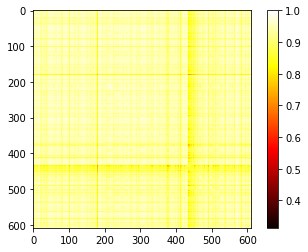

In [33]:
# Drops the movie_id value. Can be retrieved with iloc 
matrix_no_id = movie_minmax.drop('movie_id', 1)
#matrix_no_id = quantile_normalize(matrix_no_id)
# Converts dataframe to numpy array
matrix_no_id_array = matrix_no_id.to_numpy()
# Calculates cosine similarity between the movies 
cos_sim_values = compute_cos_sim_all(matrix_no_id_array)
cos_df = pd.DataFrame(cos_sim_values)
cos_df.to_csv('cos_sim_values.csv')
# Draws heatmap of the similarities between movies 
fig = plt.figure()
ax = plt.imshow(cos_sim_values, cmap='hot')
cbar = fig.colorbar(ax)
#plt.savefig('heatmap.png', dpi=3000, format='png')
plt.show

In [49]:
matrix_id = pd.DataFrame()
matrix_id['imdbId'] = movie_minmax['movie_id']
matrix_id = matrix_id.replace('\.mp4','', regex=True)
matrix_id.head()

movie_assets_trimmed = pd.read_csv('./datasets/movie_assets_trimmed.csv')
matrix_id.head()
#movie_assets_trimmed.head()
matrix_id = pd.merge(matrix_id,movie_assets_trimmed,on=["imdbId"])
matrix_id.to_csv('matrix_id.csv')
matrix_id.head()

,imdbId,assetId,title,originalTitle,genre,barn,svod
0,tt12316630,1647028,The Charm of Love,The Charm of Love,komedie,False,True
1,tt7558302,1678834,Lying and Stealing,Lying and Stealing,action,False,True
2,tt2429638,1641998,A Caretaker's Tale,Viceværten,drama,False,True
3,tt4633690,1520260,Shot Caller,Shot Caller,thriller,False,True
4,tt6146586,1557581,John Wick: Chapter 3 - Parabellum,John Wick 3: Chapter 3 - Parabellum,action,False,True


In [ ]:
matrix_id.head()

In [ ]:
print(movie_list.iloc[28])
print(movie_list.iloc[18])

In [ ]:
# Test cell for implementing polynomials in heatmap 
# Drops the movie_id value. The movie_id be retrieved with iloc 
matrix_no_id = final_matrix.drop('movie_id', 1)
# Converts dataframe to numpy array
matrix_no_id_array = matrix_no_id.to_numpy()
# Calculates cosine similarity between the movies 
#cos_sim_values = compute_cos_sim_all(matrix_no_id_array)

<h1>Data analytics</h1>

In [ ]:
# Standardising movie data
standardised_movie_data = StandardScaler().fit_transform(movie_df)


In [ ]:
# Elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init='k-means++', 
                n_init=10, max_iter=300, 
                random_state=0)
    km.fit(matrix_no_id)
    distortions.append(km.inertia_)

In [ ]:
# KMeans clustering using output from Elbow method
km_plus = KMeans(n_clusters = 8, init='k-means++', 
                n_init=10, max_iter=300, 
                random_state=0)
movie_fit = km_plus.fit_predict(movie_df)

In [ ]:
# MiniBatchSparcePCA 
transformer = MiniBatchSparsePCA(n_components=5, batch_size=50,
                                 random_state=0)
movie_mini_pca_fit = MiniBatchSparsePCA.fit_transform()

In [ ]:
# PCA 
standardised_movie_data = StandardScaler().fit_transform(movie_df)
pca = PCA(n_components = 4)
movie_pca = pca.fit_transform(standardised_movie_data)

<h1> TO DO </h1>
<p> 
    <ul>
        <li>Clustering</li>
        <li>Add deep visual features (object / action detection)</li>
        <li>Normalize all features, using log or </li>
        <li>Recommendation libraries: librec (DeepFM, FM, Wide & Deep, Youtube - recommendation) </li>
        <li> Train-test split (5 fold cross validation) </li>
        <li> precision > RMSE </li>
        <li> Correlation analysis movies ( pearson correlation) </li>
        <li> histogram difference between features </li>
        <li> more standard deviation == good!!! </li>
        <li> low cost == no ratings, high cost == more ratings </li>
        <li> high correlation, remove one </li>
        <li> random forrest, PCA </li>
</p>